In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
sns.set_theme(style="darkgrid")

sources : https://towardsdatascience.com/how-i-used-machine-learning-to-classify-emails-and-turn-them-into-insights-efed37c1e66

In [3]:
data = pd.read_csv('/Users/lucas/Desktop/Polytech/IG4/S7/projet_DS/mail_clean_EDA.csv')
df = data[0:40000]
print(data.shape)


class_mapping = {1999: 0, 2000: 1, 2001: 2, 2002: 3}

df = df.replace({'Years':class_mapping})

(99913, 46)


<center><h1>0 - Preprocessing </h1></center>

Comme dans la <b>précèdente</b> méthode de classification, il y a un <b>déséquilibre</b> des données. Nous allons donc devoir réequilibrer les donner. 

In [48]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

def over_undersample(X, valid=False):
    if valid:
        len_1999 = round(len(X)/10)
        len_2000 = round(len(X)/10)*2
        len_2001 = round(len(X)/10)*2
        len_2002 = round(len(X)/10)
    else:
        len_1999 = round(len(X)/5)
        len_2000 = round((len(X)/5))*2
        len_2001 = round((len(X)/5))*2
        len_2002 = round(len(X)/5)
    return(len_1999, len_2000, len_2001, len_2002)

In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [7]:

def punctuation_stop(text):
    """remove punctuation and stop words"""
    word_uninterested = ['subject', 'content', 'image', 'ect', 'the', 'fletch']
    filtered = []
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    for w in word_tokens:
        if (w not in stop_words) and w.isalpha() and (w.lower() not in word_uninterested) and (len(w)>2):
            filtered.append(w.lower())
    text = " ".join([ele for ele in filtered])
    return text






<center><h3>a - Vectorization</h3></center>

Les classifiers et les algorithmes d'apprentissage ne peuvent pas <b>traiter</b> directement les <b>documents textuels</b> dans leur forme originale, car la plupart d'entre eux attendent des <b>vecteurs de caractéristiques numériques de taille fixe</b> plutôt que des <b>documents textuels bruts de longueur variable</b>.

Par conséquent, lors de l'étape de <b>prétraitement</b>, nous allons convertir en une représentation plus facile à gérer.

Une approche courante pour extraire des caractéristiques du texte consiste à utiliser le modèle du <b>bag of words</b> : un modèle où pour chaque document, des mails dans notre cas, la <b>présence</b> (et souvent la fréquence) des mots est prise en considération, mais l'<b>ordre</b> dans lequel ils apparaissent est <b>ignoré</b>. Plus précisément, pour chaque terme de notre ensemble de données, nous calculerons une mesure appelée <b>Fréquence des termes, Fréquence inverse des documents</b> (Term Frequency, Inverse Document Frequency).

- <b>ngram_range</b> is set to (1, 2) pour indiquer que l'on veut les deux <b>unigrams</b> et <b>bigrams</b>.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

In [8]:
vectorizer = TfidfVectorizer(preprocessor=punctuation_stop,max_df=0.50,min_df=2, ngram_range=(1, 2)
                             )
X = vectorizer.fit_transform(df['content'])

In [19]:
type(X)

scipy.sparse.csr.csr_matrix

Tout comme dans notre autre méthode, nous devons <b>resampler</b> les données pour éviter une <b>mauvaise classification</b> au sein de chaque classe.

In [9]:
len_1999, len_2000, len_2001, len_2002 = over_undersample(df)

oversample = SMOTE(sampling_strategy={0:len_1999,3:len_2002})
undersample = RandomUnderSampler(sampling_strategy={1:len_2000,2:len_2001})



X_resample, y_resample = oversample.fit_resample(X, df['Years'])

print('After over sample:')
counter = Counter(y_resample)
for k,v in counter.items():
    per = v / len(y_resample) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
print('-'*10)
print('After under sample:')
X_resample, y_resample = undersample.fit_resample(X_resample, y_resample)
counter = Counter(y_resample)
for k,v in counter.items():
    per = v / len(y_resample) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

After over sample:
Class=2, n=19685 (36.692%)
Class=1, n=17964 (33.484%)
Class=0, n=8000 (14.912%)
Class=3, n=8000 (14.912%)
----------
After under sample:
Class=0, n=8000 (16.667%)
Class=1, n=16000 (33.333%)
Class=2, n=16000 (33.333%)
Class=3, n=8000 (16.667%)


<center><h2>b - Best features for each class</h2></center>

Nous allons utiliser le <b>chi2</b> pour trouver les <b>termes</b> qui sont le plus <b>correlés avec chaque année</b>.

In [10]:
from sklearn.feature_selection import chi2

pandas.core.series.Series

In [18]:
features = pd.concat([pd.DataFrame.sparse.from_spmatrix(X_resample),
                      y_resample.to_frame().rename(columns = {0:'Years'})] ,join='inner', axis=1)
features.columns

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
        682520,  682521,  682522,  682523,  682524,  682525,  682526,  682527,
        682528, 'Years'],
      dtype='object', length=682530)

In [12]:
X_features = features.drop(columns=['Years'])
labels = features['Years']
print('features shape',features.shape)
labels.head()

0    0
1    0
2    0
3    0
4    0
Name: Years, dtype: int64

In [21]:
N = 8
for year in [0, 1, 2, 3]:
    features = pd.concat([pd.DataFrame.sparse.from_spmatrix(X_resample),
                      y_resample.to_frame().rename(columns = {0:'Years'})] ,join='inner', axis=1)
    #features = features[features['Years']== year]
    
    X_features = features.drop(columns=['Years'])
    labels = features['Years']
 
    
    features_chi2 = chi2(X_features, labels==year)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(vectorizer.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(1999+year))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    print('-'*20)

# '0':
  . Most correlated unigrams:
. laborde
. contactable
. clothiers
. freshest
. delineator
. interpool
. internetworking
. piling
  . Most correlated bigrams:
. delivered server
. organization functions
. delivered couple
. organization equip
. internetworking today
. friday email
. attend email
. resource employees
--------------------
# '1':
  . Most correlated unigrams:
. wsc
. suffolk
. harvesting
. stoves
. geotech
. interpool
. internetworking
. gtcs
  . Most correlated bigrams:
. obviously also
. international contracts
. use activities
. easy saving
. said jack
. easy market
. complete purchase
. occur send
--------------------
# '2':
  . Most correlated unigrams:
. blackberries
. melita
. laroi
. antares
. gtcs
. experimenting
. wilkes
. vibeke
  . Most correlated bigrams:
. box immediately
. expected forwards
. gros would
. might spurred
. expected release
. might smoke
. might revised
. development little
--------------------
# '3':
  . Most correlated unigrams:
. cnet

<h2>vizualisation with PCA to understanding content.</h2>

In [ ]:
X_dense = X_features.todense()
coords = PCA(n_components=2).fit_transform(X_dense)
coords

In [ ]:
coords_df = pd.DataFrame(coords, columns=['coords0','coords1'])

coords_df = pd.concat([coords_df,data['Years']],axis=1,join='inner')
coords_df

In [ ]:
fig = px.scatter(coords_df, x='coords0', y='coords1', color='Years')
fig.show()

<center><h2> II - model building </h2> </center>

- Pour entraîner les classifiers supervisés, nous allons d'abord transformé le "content" en un vecteur de nombres. Nous allons exploré les représentations vectorielles telles que les vecteurs pondérés TF-IDF.

- Après avoir obtenu ces représentations vectorielles du texte, nous pouvons entraîner nos classifiers supervisés.

In [8]:
from sklearn.model_selection import train_test_split


from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline


In [9]:
X_train_origin, X_final_test, y_train_origin, y_final_test = train_test_split(df['content'], df['Years'], random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X_train_origin, y_train_origin, random_state = 0)




In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

In [12]:
len_1999, len_2000, len_2001, len_2002 = over_undersample(X_train)

oversample_train = SMOTE(sampling_strategy={0:len_1999,3:len_2002})
undersample_train = RandomUnderSampler(sampling_strategy={1:len_2000,2:len_2001})


classifiers = {
    'NB':MultinomialNB(),
    'Linear SVC': LinearSVC(),
    'Random Forest':RandomForestClassifier(),
    'Logistic Regression':LogisticRegression(max_iter=300),
    'Boost': XGBClassifier(),
    'Perceptron': Perceptron()
    
}
models = []
acc_training = []
acc_test = []
acc_balanced = []
matrix = []


In [15]:
for key, model in classifiers.items():
    models.append(key)
    pipeline = imbalanced_make_pipeline(TfidfVectorizer(preprocessor=punctuation_stop,max_df=0.50,min_df=2, ngram_range=(1, 2)),
                                        oversample_train, undersample_train, model)

    pipeline.fit(X_train, y_train)
    acc_training.append(pipeline.score(X_train,y_train))
    
    y_pred = pipeline.predict(X_test)
    acc_test.append(accuracy_score(y_pred, y_test))
    acc_balanced.append(balanced_accuracy_score(y_test, y_pred))
    matrix.append(confusion_matrix(y_test, y_pred))

In [23]:
result = pd.DataFrame({'model':models, 'training accuracy':acc_training, 'validation accuracy':acc_test,
                      'validation balanced accuracy': acc_balanced})
result

,model,training accuracy,validation accuracy,validation balanced accuracy
0,NB,0.942756,0.885867,0.804540
1,Linear SVC,0.979333,0.918400,0.891794
2,Random Forest,0.985556,0.910000,0.854889
3,Logistic Regression,0.967689,0.903333,0.870889
4,Boost,0.737244,0.721067,0.658606
5,Perceptron,0.985778,0.919067,0.877020


In [27]:
result.to_csv('/Users/lucas/Desktop/Polytech/IG4/S7/projet_DS/CSV/result_first_training.csv',index=False)
fig = go.Figure(data=[
    go.Bar(name='training accuracy', x=result['model'].to_numpy(), y=result['training accuracy'].to_numpy()),
    go.Bar(name='validation accuracy', x=result['model'].to_numpy(), y=result['validation accuracy'].to_numpy()),
    go.Bar(name='balanced validation accuracy', x=result['model'].to_numpy(), y=result['validation balanced accuracy'].to_numpy())
          ])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()


- Nos modèles semblent globalement <b>performant</b>, cependant ils <b>overfit</b> les données.

- Le <b>XgboostClassifier</b> est celui qui <b>overfit</b> le moins les données cependant il est très <b>largement</b> en dessous des autres classifier.  On va donc s'en passer pour l'instant.

<center><h3> III - cross validation</h3></center>

In [30]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    LogisticRegression(max_iter=300),
    Perceptron()
]
len_1999, len_2000, len_2001, len_2002 = over_undersample(X_train_origin, valid=True)

oversample_train_valid = SMOTE(sampling_strategy={0:len_1999,3:len_2002})
undersample_train_valid = RandomUnderSampler(sampling_strategy={1:len_2000,2:len_2001})

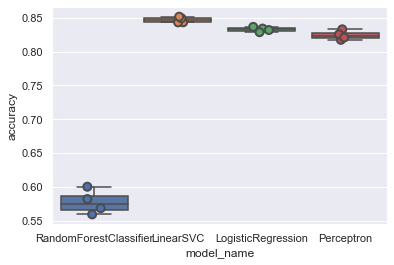

In [32]:
CV = 4
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    pipeline = imbalanced_make_pipeline(TfidfVectorizer(preprocessor=punctuation_stop,max_df=0.50,min_df=2, ngram_range=(1, 2)),
                                        oversample_train_valid, undersample_train_valid, model)
    model_name = model.__class__.__name__
    accuracies = cross_val_score(pipeline, X_train_origin, y_train_origin, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    
    
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                          size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [49]:
cv_df.to_csv('/Users/lucas/Desktop/Polytech/IG4/S7/projet_DS/CSV/crossval_boxplot.csv',index=False)
fig = px.box(cv_df, x="model_name", y="accuracy", points="all")
fig.show()

<center><h2>IV - Fine tuning model</h2></center>

In [33]:
from sklearn.model_selection import GridSearchCV

In [50]:
models_tune = []
best_scores = []

In [51]:
def tuning(classifier, params, X, y):
    len_1999, len_2000, len_2001, len_2002 = over_undersample(X, True)
    pipeline_clf = imbalanced_make_pipeline(TfidfVectorizer(preprocessor=punctuation_stop,max_df=0.50,min_df=2, ngram_range=(1, 2)),
                                            SMOTE(), RandomUnderSampler(), classifier)
    
    params['smote__sampling_strategy']= [{0:len_1999, 3:len_2002}]
    params['randomundersampler__sampling_strategy']=[{1:len_2000, 2:len_2001}] 
    
    grid_clf = GridSearchCV(estimator = pipeline_clf, param_grid = params, scoring='balanced_accuracy' )
    grid_clf.fit(X, y)
    
    return grid_clf

<br>

- <b>LinearSVC</b>

In [ ]:
Cs = [0.001, 0.01, 0.1]
param_grid = {'linearsvc__C': Cs}

grid_lsvc = tuning(LinearSVC(), param_grid, X_train_origin, y_train_origin)



In [54]:
print(grid_lsvc.best_estimator_)
print(grid_lsvc.best_score_)

models_tune.append("Linear SVC")
best_scores.append(grid_lsvc.best_score_)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 2),
                                 preprocessor=<function punctuation_stop at 0x7febcf839710>)),
                ('smote', SMOTE(sampling_strategy={0: 3000, 3: 3000})),
                ('randomundersampler',
                 RandomUnderSampler(sampling_strategy={1: 6000, 2: 6000})),
                ('linearsvc', LinearSVC(C=0.1))])
0.8560729166655283


<br>

- <b> Perceptron</b>

In [55]:
alphas = [0.001, 0.01, 0.1]
tols = [0.001, 0.01, 0.1]

param_grid = {'perceptron__alpha': alphas, 'perceptron__tol':tols}
grid_perc = tuning(Perceptron(), param_grid, X_train_origin, y_train_origin)

print(grid_perc.best_estimator_)
print(grid_perc.best_score_)

models_tune.append("Perceptron")
best_scores.append(grid_perc.best_score_)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 2),
                                 preprocessor=<function punctuation_stop at 0x7febcf839710>)),
                ('smote', SMOTE(sampling_strategy={0: 3000, 3: 3000})),
                ('randomundersampler',
                 RandomUnderSampler(sampling_strategy={1: 6000, 2: 6000})),
                ('perceptron', Perceptron(alpha=0.1))])
0.881930188644105


<br>

- <b> Logistic Regression </b>

In [ ]:
Cs = [ 0.01, 0.1, 1]
max_iters = range(100,401, 100)
param_grid = {'logisticregression__C': Cs, 'logisticregression__max_iter':max_iters}

grid_lr = tuning(LogisticRegression(), param_grid, X_train_origin, y_train_origin)

print(grid_lr.best_estimator_)
print(grid_lr.best_score_)

models_tune.append("LogisticRegression")
best_scores.append(grid_lr.best_score_)

/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/o

In [ ]:
result = pd.DataFrame{'model tune':models_tune, 'best score balanced accuracy': best_scores}
result

In [21]:
result.to_csv('/Users/lucas/Desktop/Polytech/IG4/S7/projet_DS/CSV/result_fine_tuning.csv',index=False)
fig = go.Figure(data=[
    go.Bar(name='training accuracy', x=result['model tune'].to_numpy(), y=result['best score balanced accuracy'].to_numpy()),
   
          ])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

<b>Est ce que nos modèles sont toujours en overfitting?</b>

In [24]:
models_tunes = { 'linearsvc':LinearSVC(C=0.1),
                'Perceptron': Perceptron(alpha=0.1),     
    
}

len_1999, len_2000, len_2001, len_2002 = over_undersample(X_train)
oversample_train = SMOTE(sampling_strategy={0:len_1999,3:len_2002})
undersample_train = RandomUnderSampler(sampling_strategy={1:len_2000,2:len_2001})


name_model = []
acc_train = []
acc_valid = []
acc_balanced = []

for key, value in models_tunes.items():
    name_model.append(key)
    pipeline = imbalanced_make_pipeline(TfidfVectorizer(preprocessor=punctuation_stop,max_df=0.50,min_df=2, ngram_range=(1, 2)),
                                        oversample_train, undersample_train, value)
    pipeline.fit(X_train, y_train)
    acc_train.append(pipeline.score(X_train, y_train))
    
    y_pred = pipeline.predict(X_test)
    acc_valid.append(accuracy_score(y_pred, y_test))
    acc_balanced.append(balanced_accuracy_score(y_pred, y_test))

<center><h2>V - Final Test</h2></center>

In [26]:
import time
accuracies = []
balanced_accuracies = []
train_time = []
predict_time = []

- <b>Perceptron</b>

In [ ]:
len_1999, len_2000, len_2001, len_2002 = over_undersample(X_train_origin)
oversample_train_origin = SMOTE(sampling_strategy={0:len_1999, 3:len_2002})
undersample_train_origin = RandomUnderSampler(sampling_strategy={1:len_2000, 2:len_2001})

percept = Perceptron(alpha=0.1)

pipeline = imbalanced_make_pipeline(TfidfVectorizer(preprocessor=punctuation_stop,max_df=0.50,min_df=2, ngram_range=(1, 2)),
                                    oversample_train_origin, undersample_train_origin, percept)

####### Fit Train Set + Measure Time #######
start = time.time()
pipeline.fit(X_train_origin, y_train_origin)
stop = time.time()
train_time.append(stop-start)

###### Predict Final Test Set + Measure Time ######
start = time.time()
y_pred_perc = pipeline.predict(X_final_test)
stop = time.time()
predict_time.append(stop-start)

########### accuracy metrics###########
print('PERCEPTRON CLASSIFIER:')
print('accuracy on final test: ', accuracy_score(y_pred_perc, y_final_test))
print('balanced accuracy on final test: ', balanced_accuracy_score(y_pred_perc, y_final_test))

accuracies.append(accuracy_score(y_pred_perc, y_final_test))
balanced_accuracies.append(balanced_accuracy_score(y_pred_perc, y_final_test))

In [62]:
len_1999, len_2000, len_2001, len_2002 = over_undersample(X_train_origin)
oversample_train_origin = SMOTE(sampling_strategy={0:len_1999, 3:len_2002})
undersample_train_origin = RandomUnderSampler(sampling_strategy={1:len_2000, 2:len_2001})

percept = Perceptron(alpha=0.1)

pipeline = imbalanced_make_pipeline(TfidfVectorizer(preprocessor=punctuation_stop,max_df=0.50,min_df=2, ngram_range=(1, 2)),
                                    oversample_train_origin, undersample_train_origin, percept)

####### Fit Train Set + Measure Time #######
start = time.time()
pipeline.fit(X_train_origin, y_train_origin)
stop = time.time()
train_time.append(stop-start)

###### Predict Final Test Set + Measure Time ######
start = time.time()
y_pred_perc = pipeline.predict(X_final_test)
stop = time.time()
predict_time.append(stop-start)

########### accuracy metrics###########
print('PERCEPTRON CLASSIFIER:')
print('accuracy on final test: ', accuracy_score(y_pred_perc, y_final_test))
print('balanced accuracy on final test: ', balanced_accuracy_score(y_pred_perc, y_final_test))

accuracies.append(accuracy_score(y_pred_perc, y_final_test))
balanced_accuracies.append(balanced_accuracy_score(y_pred_perc, y_final_test))